In [5]:
import csv
import os
import math
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import gensim
import torch
import torch.nn.functional as F
from datetime import datetime
from torchvision.transforms import transforms
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [6]:
np.random.seed(5)

In [7]:
TRAIN_PERCENTAGE = 0.8
LR = 0.003
EPOCHS = 256
THRESHOLD = 0.5
MOMENTUM = 0.75

In [8]:
def readData(filename, inputLabels, outputLabels = ['Sentiment']):
    df = pd.read_csv(filename)
    #df.fillna(df.mean(), inplace=True)

    inputs = [] 
    target = [] 

    for _, row in df.iterrows():
        inputs.append([row[x] for x in inputLabels])
        target.append([row[x] for x in outputLabels])
    
    if len(inputLabels) == 1:
        inputs = np.squeeze(inputs)
    if len(outputLabels) == 1:
        target = np.squeeze(target)
    return inputs, target, list(set(target)) 

In [9]:
def transformOutputs(outputs):
    d = dict()
    val = 0
    for o in outputs:
        if o not in d:
            d[o] = val
            val += 1
    return [d[val] for val in outputs] 

In [11]:
file = os.path.join(os.getcwd(), 'data', 'reviews_mixed.csv')
inputsLabels = ['Text']
outputsLabels = ['Sentiment']
inputs, outputs, labelNames = readData(file, inputsLabels, outputsLabels)
outputs = transformOutputs(outputs)

In [36]:
np.random.seed(5)
noSamples = len(inputs)
indexes = [i for i in range(noSamples)]
trainSample = np.random.choice(indexes, int(TRAIN_PERCENTAGE * noSamples), replace = False)
testSample = [i for i in indexes  if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]
testInputs = [inputs[i] for i in testSample]
testOutputs = [outputs[i] for i in testSample]

print(trainInputs[:3])

['still easy to reach.', 'Some thinks didnt work well : air, tv , open windows,', 'Room was not cleaned even once during our stay.']


In [13]:
modelPath = os.path.join(os.getcwd(), 'models', 'GoogleNews-vectors-negative300.bin')

word2vecModel = gensim.models.KeyedVectors.load_word2vec_format(modelPath, binary = True)
print(word2vecModel.most_similar('support'))

[('supporting', 0.6251285076141357), ('suport', 0.6071150302886963), ('suppport', 0.6053199768066406), ('Support', 0.6044272780418396), ('supported', 0.6009396910667419), ('backing', 0.6007589101791382), ('supports', 0.5269277095794678), ('assistance', 0.520713746547699), ('sup_port', 0.5192490220069885), ('supportive', 0.5110024809837341)]


In [14]:
def featureComputation(model, data):
    features = []
    phrases = [phrase.split() for phrase in data]

    for phrase in phrases:
        vectors = [model[word] for word in phrase if (len(word) > 2) and (word in model.key_to_index)]
        if len(vectors) == 0:
            result = [0.0] * model.vector_size
        else:
            result = np.sum(vectors, axis = 0) / len(vectors)
        features.append(result)
    return features

trainFeatures = featureComputation(word2vecModel, trainInputs)
testFeatures = featureComputation(word2vecModel, testInputs)

In [15]:
unsupervisedClassifier = KMeans(n_clusters=2, random_state=0)
unsupervisedClassifier.fit(trainFeatures)

/Users/victorzarzu/miniconda3/envs/torch-gpu/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [16]:
predicted = unsupervisedClassifier.predict(testFeatures)

In [17]:
print("acc: ", accuracy_score(testOutputs, predicted))

acc:  0.35714285714285715


In [21]:
class EmNet(torch.nn.Module):

    def __init__(self):
        super(EmNet, self).__init__()

        self.l1 = torch.nn.Linear(300, 128)
        self.l2 = torch.nn.Linear(128, 32)
        self.l3 = torch.nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.sigmoid(self.l3(x))

        return x

In [22]:
model = EmNet()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, weight_decay = 1e-3)
loss_fn = torch.nn.BCELoss()

In [23]:
def train_one_epoch(trainFeatures, trainOutputs):
    avg_loss = 0
    avg_accuracy = 0

    for data, label in zip(trainFeatures, trainOutputs):

        optimizer.zero_grad()

        output = model.forward(torch.from_numpy(np.array(data)).float())

        label_tensor = torch.tensor(label, dtype=torch.float32).reshape(output.shape)
        loss = loss_fn(output, label_tensor)
        loss.backward()

        optimizer.step()


In [24]:
def stats(model, inputs, outputs):
    avg_loss = 0
    avg_accuracy = 0
    for data, label in zip(inputs, outputs):
        output = model(torch.from_numpy(np.array(data)).float())
        label_tensor = torch.tensor(label, dtype=torch.float32).reshape(output.shape)
        loss = loss_fn(output, label_tensor)
        avg_loss += loss.item()

        output = 1 if output.item() > THRESHOLD else 0
        if output == label:
            avg_accuracy += 1
    
    return avg_loss / len(inputs), avg_accuracy / len(inputs)

In [25]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = torch.utils.tensorboard.SummaryWriter('./runs/sepia_filter_{}'.format(timestamp))

def train(model, trainFeatures, trainOutputs):

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    for epoch in range(EPOCHS):

        model.train(True)
        train_one_epoch(trainFeatures, trainOutputs)
        model.train(False)

        avg_loss, avg_accuracy = stats(model, trainFeatures, trainOutputs)
        train_acc.append(avg_accuracy)
        train_loss.append(avg_loss)

        running_vloss = 0
        avg_vaccuracy = 0
        """
        for _, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels.unsqueeze(1).float())
            avg_vaccuracy += compute_accuracy(voutputs, vlabels)
            running_vloss  += vloss.item()
        
        avg_vloss = running_vloss / (len(val_loader) + 1)
        avg_vaccuracy  = avg_vaccuracy / len(val_loader)
        val_acc.append(avg_vaccuracy)
        val_loss.append(avg_vloss)
        """
        if epoch % 50 == 0:
            print('EPOCH {}'.format(epoch + 1))
        ##print('LOSS train_loss = {} train_acc = {} val_loss = {} val_acc = {}'.format(avg_loss, avg_accuracy, avg_vloss, avg_vaccuracy))
        #writer.add_scalars('Training vs. Validation Loss',
        #                   {'Training': avg_loss, 'Validation': avg_vloss},
        #                   epoch + 1)
        #writer.flush()
    
    return train_acc, train_loss, val_acc, val_loss

In [27]:
train_acc, train_loss, val_acc, val_loss = train(model, trainFeatures, trainOutputs)

EPOCH 1
EPOCH 51
EPOCH 101
EPOCH 151
EPOCH 201
EPOCH 251


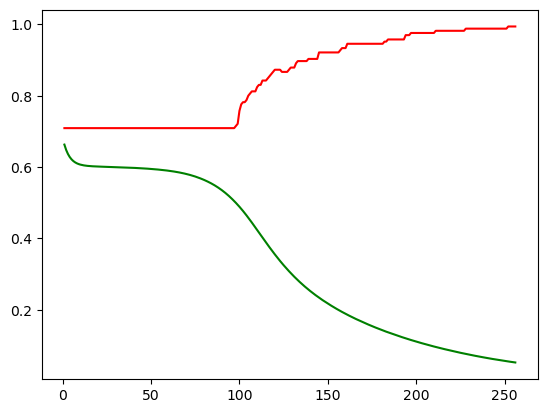

In [28]:
def plot_stats(train_acc, train_loss, val_acc, val_loss):
    rng = list(range(1, EPOCHS + 1))
    plt.plot(rng, train_acc, '-r')
    plt.plot(rng, train_loss, '-g')

plot_stats(train_acc, train_loss, val_acc, val_loss)

In [44]:
def compute_accuracy(predicted, labels):
    predicted = [1 if pred > THRESHOLD else 0 for pred in predicted]
    return sum([p == l for p, l in zip(predicted, labels)]) / len(predicted)

In [128]:
predicted = [model(torch.from_numpy(np.array(val)).float()).item() for val in trainFeatures]
print('train acc = ', compute_accuracy(predicted, trainOutputs))

train acc =  0.9939393939393939


In [129]:
predicted = [model(torch.from_numpy(np.array(val)).float()).item() for val in testFeatures]
print('test acc = ', compute_accuracy(predicted, testOutputs))

test acc =  0.6904761904761905


In [170]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers.legacy import Nadam

x_train = trainInputs
y_train = np.array(trainOutputs)

max_words = 1000
max_len = 100
embedding_dim = 16 
num_filters = 32 
filter_size = 5 
hidden_dims = 64 
batch_size = 16 
epochs = 10  
learning_rate = 0.01

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(trainInputs)
sequences = tokenizer.texts_to_sequences(trainInputs)

x_train = pad_sequences(sequences, maxlen=max_len)

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(num_filters, filter_size, activation='selu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='selu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

optimizer = Nadam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/10
11/11 [==============================] - 0s 2ms/step - loss: 0.5941 - accuracy: 0.6848
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.5025 - accuracy: 0.7636
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 0.3216 - accuracy: 0.8970
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 0.0749 - accuracy: 0.9758
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 9.8101e-04 - accuracy: 1.0000
Epoch 8/10
11/11 [==============================] - 0s 2ms/step - loss: 7.5811e-04 - accuracy: 1.0000
Epoch 9/10
11/11 [==============================] - 0s 2ms/step - loss: 5.5461e-04 - accuracy: 1.0000
Epoch 10/10
11/11 [==============================] - 0s 2ms/step - loss: 5.8018e-04 - accuracy: 1.0000


In [171]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(testInputs)
sequences = tokenizer.texts_to_sequences(testInputs)

x_test = pad_sequences(sequences, maxlen=max_len)

predicted = model(x_test)
print("test acc: ", compute_accuracy(predicted, testOutputs))

test acc:  0.7142857142857143


In [29]:
def get_negative_positive(texts):
    concatenated = " ".join(texts)
    sia = SentimentIntensityAnalyzer()
    
    tokens = nltk.word_tokenize(concatenated)

    negative_words = []
    positive_words = []
    for word in tokens:
        score = sia.polarity_scores(word)['compound']
        if score > 0:
            positive_words.append(word)
        elif score < 0:
            negative_words.append(word)
    
    return negative_words, positive_words

In [30]:
def embed_text(text, negative_words, positive_words):
    result = []
    for word in positive_words:
        result.append(text.count(word))
    for word in negative_words:
        result.append(text.count(word))
    
    return result

In [31]:
def embed_texts(texts, negative_words, positive_words):
    return [embed_text(text, negative_words, positive_words) for text in texts]

In [46]:
negative_words, positive_words = get_negative_positive(trainInputs)
trainFeatures = embed_texts(trainInputs, positive_words, negative_words)
testFeatures = embed_texts(testInputs, positive_words, negative_words)

In [39]:
class EmCNet(torch.nn.Module):

    def __init__(self):
        super(EmCNet, self).__init__()

        self.l1 = torch.nn.Linear(134, 63)
        self.l2 = torch.nn.Linear(63, 16)
        self.l3 = torch.nn.Linear(16, 1)
    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.sigmoid(self.l3(x))

        return x

In [40]:
model = EmCNet()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, weight_decay = 1e-3)
loss_fn = torch.nn.BCELoss()

In [42]:
train_acc, train_loss, val_acc, val_loss = train(model, trainFeatures, trainOutputs)

EPOCH 1
EPOCH 51
EPOCH 101
EPOCH 151
EPOCH 201
EPOCH 251


In [45]:
predicted = [model(torch.from_numpy(np.array(val)).float()).item() for val in trainFeatures]
print('train acc = ', compute_accuracy(predicted, trainOutputs))

train acc =  0.9090909090909091


In [47]:
predicted = [model(torch.from_numpy(np.array(val)).float()).item() for val in testFeatures]
print('train acc = ', compute_accuracy(predicted, testOutputs))

train acc =  0.7857142857142857
